In [1]:
# Energy Forecasting - Vinergy

Loading essential libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np ;
import pandas as pd ;
import seaborn as sb ;
import datetime as dt ;
import matplotlib.pyplot as plt ;
import tensorflow as tf ;
from keras import models, layers ;
from sklearn.model_selection import GridSearchCV ;
from sklearn.metrics import mean_absolute_error, r2_score ;

In [4]:
energy = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Demand Data upto Feb 21.csv') ;
energy.head()

,datetime,Demand (MW)
0,1/1/2020 0:00,445.8
1,1/1/2020 1:00,424.5
2,1/1/2020 2:00,423.5
3,1/1/2020 3:00,418.8
4,1/1/2020 4:00,414.8


Expolatory Data Analysis & Preprocessing

In [5]:
energy.isnull().sum()

datetime       0
Demand (MW)    0
dtype: int64

There are no null values in the dataset

In [6]:
def populateWithTimeFeatures(table, dtColumn):
  table.index = pd.to_datetime(table[dtColumn]) ;
  table['Hour'] = table.index.hour ;
  table['Day'] = table.index.day ;
  table['Quarter'] = table.index.quarter ;
  table['Month_Numbered'] = table.index.month ;
  table['Month'] = table.index.month_name() ;
  table['Year'] = table.index.year ;
  table['Week'] = table.index.isocalendar().week ;
  table['Weekday'] = table.index.day_name() ;
  table = table.sort_index() ;
  return table ;

In [7]:
energy = populateWithTimeFeatures(energy, 'datetime') ;
energy

,datetime,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday
datetime,,,,,,,,,,
2020-01-01 00:00:00,1/1/2020 0:00,445.8,0,1,1,1,January,2020,1,Wednesday
2020-01-01 01:00:00,1/1/2020 1:00,424.5,1,1,1,1,January,2020,1,Wednesday
2020-01-01 02:00:00,1/1/2020 2:00,423.5,2,1,1,1,January,2020,1,Wednesday
2020-01-01 03:00:00,1/1/2020 3:00,418.8,3,1,1,1,January,2020,1,Wednesday
2020-01-01 04:00:00,1/1/2020 4:00,414.8,4,1,1,1,January,2020,1,Wednesday
...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,2/21/2023 19:00,498.7,19,21,1,2,February,2023,8,Tuesday
2023-02-21 20:00:00,2/21/2023 20:00,498.8,20,21,1,2,February,2023,8,Tuesday
2023-02-21 21:00:00,2/21/2023 21:00,506.4,21,21,1,2,February,2023,8,Tuesday


In [8]:
weeks = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7} ;
reverse_weeks = {value: key for key, value in weeks.items()} ;
weeks

{'Monday': 1,
 'Tuesday': 2,
 'Wednesday': 3,
 'Thursday': 4,
 'Friday': 5,
 'Saturday': 6,
 'Sunday': 7}

In [9]:
energy = energy.drop_duplicates() ;
energy

,datetime,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday
datetime,,,,,,,,,,
2020-01-01 00:00:00,1/1/2020 0:00,445.8,0,1,1,1,January,2020,1,Wednesday
2020-01-01 01:00:00,1/1/2020 1:00,424.5,1,1,1,1,January,2020,1,Wednesday
2020-01-01 02:00:00,1/1/2020 2:00,423.5,2,1,1,1,January,2020,1,Wednesday
2020-01-01 03:00:00,1/1/2020 3:00,418.8,3,1,1,1,January,2020,1,Wednesday
2020-01-01 04:00:00,1/1/2020 4:00,414.8,4,1,1,1,January,2020,1,Wednesday
...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,2/21/2023 19:00,498.7,19,21,1,2,February,2023,8,Tuesday
2023-02-21 20:00:00,2/21/2023 20:00,498.8,20,21,1,2,February,2023,8,Tuesday
2023-02-21 21:00:00,2/21/2023 21:00,506.4,21,21,1,2,February,2023,8,Tuesday


In [10]:
energy['Weekday_Numbered'] = energy['Weekday'].map(weeks) ;
energy = energy.drop('datetime', axis=1) ;
energy

,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered
datetime,,,,,,,,,,
2020-01-01 00:00:00,445.8,0,1,1,1,January,2020,1,Wednesday,3
2020-01-01 01:00:00,424.5,1,1,1,1,January,2020,1,Wednesday,3
2020-01-01 02:00:00,423.5,2,1,1,1,January,2020,1,Wednesday,3
2020-01-01 03:00:00,418.8,3,1,1,1,January,2020,1,Wednesday,3
2020-01-01 04:00:00,414.8,4,1,1,1,January,2020,1,Wednesday,3
...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,498.7,19,21,1,2,February,2023,8,Tuesday,2
2023-02-21 20:00:00,498.8,20,21,1,2,February,2023,8,Tuesday,2
2023-02-21 21:00:00,506.4,21,21,1,2,February,2023,8,Tuesday,2


In [11]:
dayEnergy = energy.groupby('Weekday_Numbered', sort=True).agg('mean', numeric_only=True) ;
sorted = dayEnergy.sort_values(by='Demand (MW)', ascending=False) ;
print(f'Highest average consumption of energy per a week day : {sorted.iloc[0,0]} MW is observed on {reverse_weeks[sorted.index[0]]}. ') ;
del sorted ;

Highest average consumption of energy per a week day : 574.4161585365854 MW is observed on Wednesday. 


In [12]:
dayEnergy

,Demand (MW),Hour,Day,Quarter,Month_Numbered,Year,Week
Weekday_Numbered,,,,,,,
1,560.286789,11.5,15.823171,2.426829,6.256098,2021.097561,25.743902
2,572.000711,11.5,15.713415,2.426829,6.292683,2021.097561,25.743902
3,574.416159,11.5,15.463415,2.439024,6.323171,2021.079268,25.70122
4,570.979954,11.5,15.536585,2.457317,6.353659,2021.079268,25.70122
5,563.755335,11.5,15.609756,2.457317,6.310976,2021.085366,25.70122
6,518.698653,11.5,15.676829,2.445122,6.268293,2021.091463,25.70122
7,502.664914,11.5,15.750000,2.426829,6.225610,2021.097561,25.70122


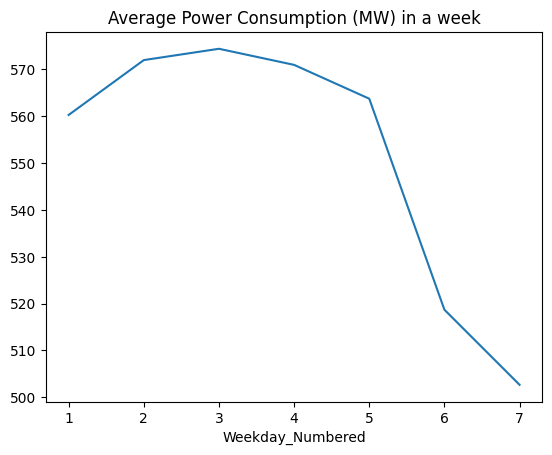

In [13]:
dayEnergy['Demand (MW)'].plot(title='Average Power Consumption (MW) in a week') ;

In [14]:
year = 2020 ;
month = 'July' ;
day = 1 ;

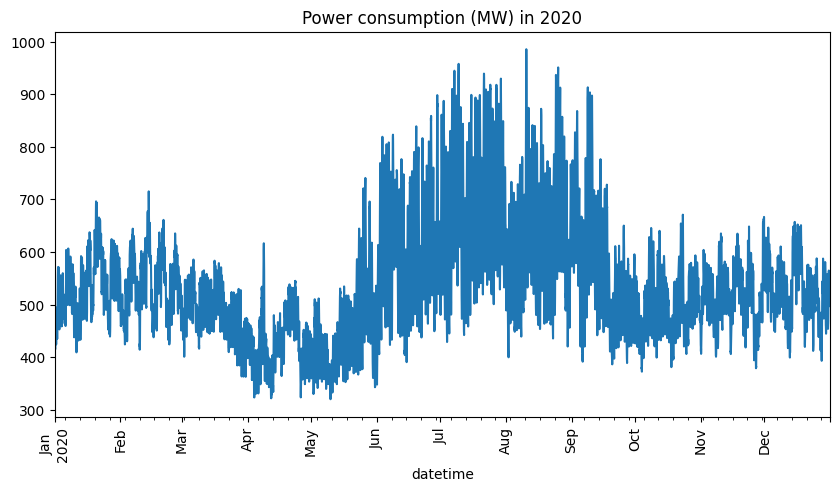

In [15]:
plt.figure(figsize=(10,5))
energy[(energy['Year'] == year)]['Demand (MW)'].plot(title=f'Power consumption (MW) in {year}', rot=90) ;

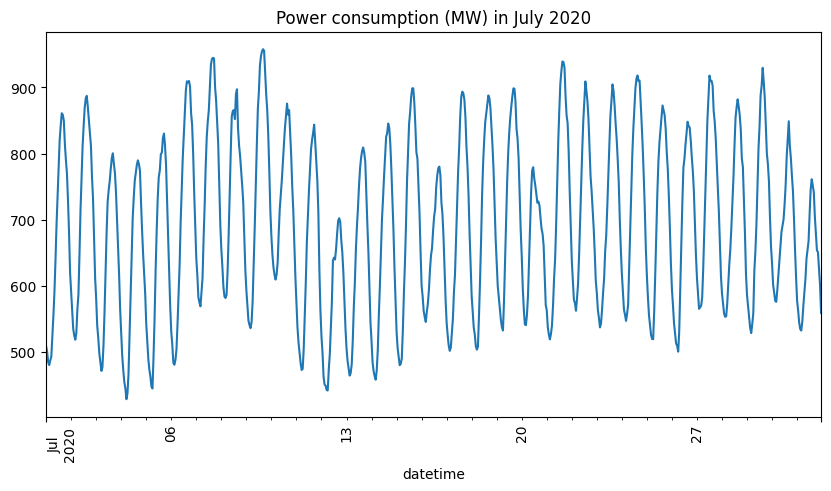

In [16]:
plt.figure(figsize=(10,5)) ;
energy[(energy['Year'] == year) & (energy['Month'] == month)]['Demand (MW)'].plot(title=f'Power consumption (MW) in {month} {year}', rot=90) ;

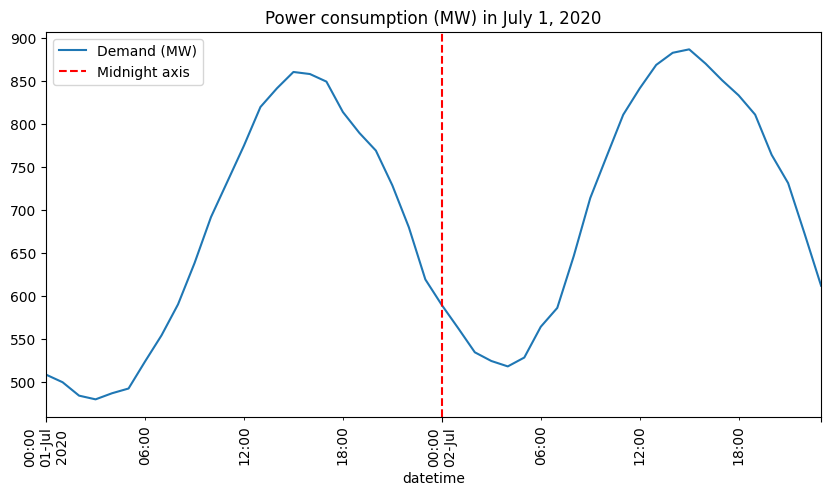

In [17]:
plt.figure(figsize=(10,5)) ;
title = f'Power consumption (MW) in {month} {day}, {year}' ;
energy[(energy['Year'] == year) & (energy['Month'] == month) & ((energy['Day'] == day) | (energy['Day'] == day+1))]['Demand (MW)'].plot(title=title, rot=90) ;
plt.axvline(x=f"{year}-{month}-{day+1} 00:00:00", linestyle='--', color='red', label='Midnight axis') ;
plt.legend() ;

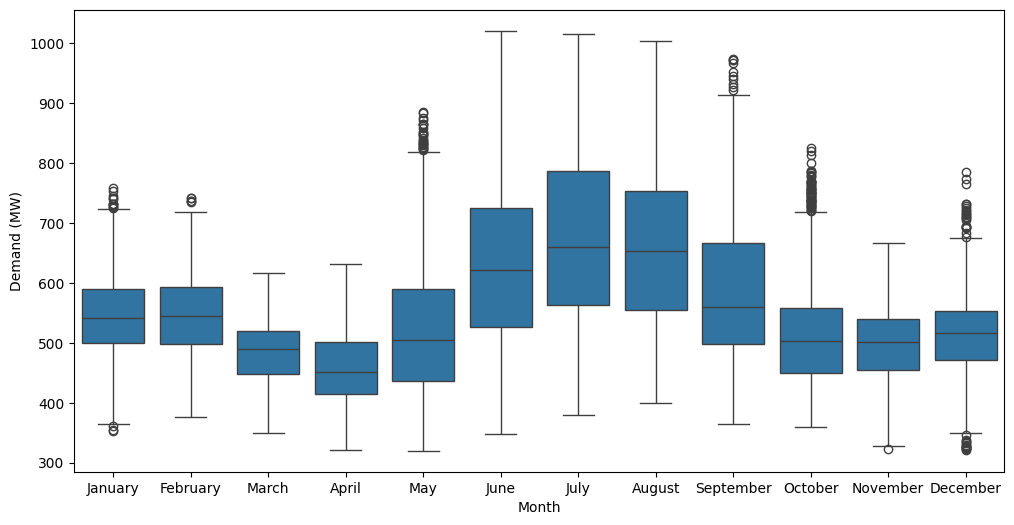

In [18]:
plt.figure(figsize=(12,6)) ;
sb.boxplot(x=energy['Month'], y=energy['Demand (MW)']) ;

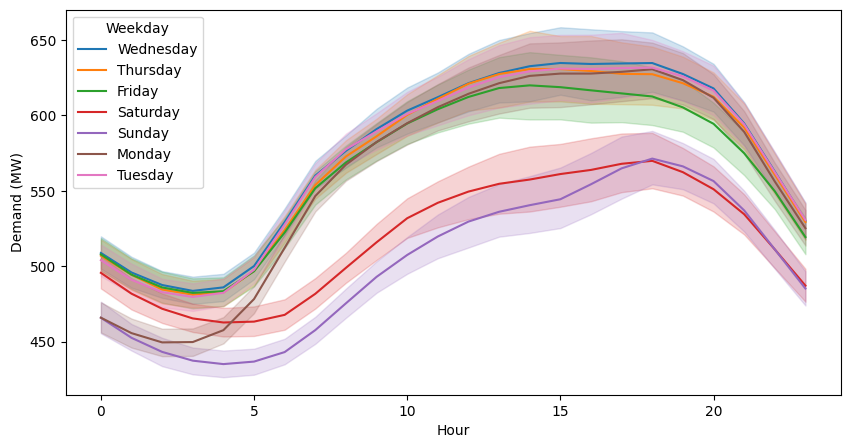

In [19]:
plt.figure(figsize=(10,5)) ;
sb.lineplot(x=energy['Hour'], y=energy['Demand (MW)'], hue=energy['Weekday']) ;

In [20]:
weather = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Weather Data upto Feb 28.csv') ;
weather

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
0,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
1,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
3,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
4,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27715,Pokhara,2/28/2023 19:00,56.0,56.0,39.8,54.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
27716,Pokhara,2/28/2023 20:00,52.1,52.1,41.0,65.83,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
27717,Pokhara,2/28/2023 21:00,53.1,53.1,41.0,63.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
27718,Pokhara,2/28/2023 22:00,55.1,55.1,41.0,58.85,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN


In [21]:
weather.index = pd.to_datetime(weather['datetime']) ;
weather = weather.sort_index() ;
weather

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,Pokhara,2/28/2023 19:00,56.0,56.0,39.8,54.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 20:00:00,Pokhara,2/28/2023 20:00,52.1,52.1,41.0,65.83,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 21:00:00,Pokhara,2/28/2023 21:00,53.1,53.1,41.0,63.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN


In [22]:
weather.describe()

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windgust,windspeed,...,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
count,27720.000000,27720.000000,27720.000000,27720.000000,27720.000000,27720.000000,27702.000000,27702.000000,12223.000000,27720.000000,...,27702.000000,27720.000000,27702.000000,27720.000000,27720.000000,9954.000000,0.0,0.0,0.0,0.0
mean,56.846847,55.505018,45.486089,68.485757,0.005618,6.908369,0.001205,0.044258,15.449611,6.499069,...,1018.008913,39.796815,9.183842,163.639946,1.614430,13.055957,NaN,NaN,NaN,NaN
std,18.734390,21.558142,18.198644,18.189507,0.044799,25.360098,0.041213,0.377761,8.627404,4.765840,...,6.702345,44.949277,1.902787,265.417780,2.662525,13.499753,NaN,NaN,NaN,NaN
min,-5.900000,-30.100000,-14.900000,17.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,...,991.400000,0.000000,0.000000,0.000000,0.000000,3.000000,NaN,NaN,NaN,NaN
25%,42.200000,38.000000,29.900000,55.172500,0.000000,0.000000,0.000000,0.000000,8.300000,3.400000,...,1013.900000,0.000000,9.900000,0.000000,0.000000,10.000000,NaN,NaN,NaN,NaN
50%,56.900000,56.900000,46.100000,70.540000,0.000000,0.000000,0.000000,0.000000,14.300000,5.800000,...,1017.500000,0.000000,9.900000,12.000000,0.000000,10.000000,NaN,NaN,NaN,NaN
75%,72.000000,72.000000,62.100000,83.960000,0.000000,0.000000,0.000000,0.000000,21.900000,9.200000,...,1022.300000,100.000000,9.900000,222.000000,2.000000,10.000000,NaN,NaN,NaN,NaN
max,99.000000,110.400000,79.100000,100.000000,2.376000,100.000000,4.700000,5.780000,57.500000,38.000000,...,1041.500000,100.000000,34.900000,1197.000000,10.000000,100.000000,NaN,NaN,NaN,NaN


In [23]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27720 entries, 2020-01-01 00:00:00 to 2023-02-28 23:00:00
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              27720 non-null  object 
 1   datetime          27720 non-null  object 
 2   Temperature       27720 non-null  float64
 3   feelslike         27720 non-null  float64
 4   dewpoint          27720 non-null  float64
 5   humidity          27720 non-null  float64
 6   precipitation     27720 non-null  float64
 7   precipprob        27720 non-null  int64  
 8   preciptype        2751 non-null   object 
 9   snow              27702 non-null  float64
 10  snowdepth         27702 non-null  float64
 11  windgust          12223 non-null  float64
 12  windspeed         27720 non-null  float64
 13  winddirection     27720 non-null  float64
 14  sealevelpressure  27702 non-null  float64
 15  cloudcover        27720 non-null  float64
 16  visib

In [24]:
weather.isnull().sum()

Name                    0
datetime                0
Temperature             0
feelslike               0
dewpoint                0
humidity                0
precipitation           0
precipprob              0
preciptype          24969
snow                   18
snowdepth              18
windgust            15497
windspeed               0
winddirection           0
sealevelpressure       18
cloudcover              0
visibility             18
solarradiation          0
uvindex                 0
severerisk          17766
conditions              0
Unnamed: 21         27720
Unnamed: 22         27720
Unnamed: 23         27720
Unnamed: 24         27720
Unnamed: 25         27719
dtype: int64

In [25]:
weather = weather.drop_duplicates() ;
weather

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Partially cloudy,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,NaN,Clear,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,Pokhara,2/28/2023 19:00,56.0,56.0,39.8,54.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 20:00:00,Pokhara,2/28/2023 20:00,52.1,52.1,41.0,65.83,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN
2023-02-28 21:00:00,Pokhara,2/28/2023 21:00,53.1,53.1,41.0,63.45,0.0,0,NaN,0.0,...,9.9,0.0,0,10.0,Clear,NaN,NaN,NaN,NaN,NaN


Dropping the columns that are massively empty or not relevant !

In [26]:
weather['severerisk'].unique()

array([ nan,  10.,   3.,   5.,  30.,   8.,  60.,  15.,  75., 100.,  19.,
        25.,  50.,  38.])

In [27]:
weather['severerisk'] = weather['severerisk'].fillna(1.0) ;
weather.head()

,Name,datetime,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,preciptype,snow,...,visibility,solarradiation,uvindex,severerisk,conditions,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,Pokhara,1/1/2020 0:00,38.0,34.4,29.0,69.76,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,Pokhara,1/1/2020 1:00,38.0,34.4,29.9,72.37,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,Pokhara,1/1/2020 2:00,38.0,35.7,30.8,75.06,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Overcast,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,Pokhara,1/1/2020 3:00,37.1,33.4,29.9,74.97,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Partially cloudy,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,Pokhara,1/1/2020 4:00,35.1,32.3,29.0,78.41,0.0,0,NaN,0.0,...,9.9,0.0,0,1.0,Clear,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Temperature', ylabel='severerisk'>

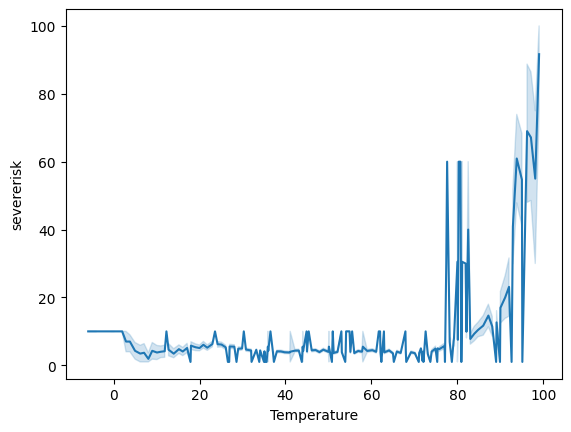

In [69]:
sb.lineplot(data = weather, x='Temperature', y='severerisk')

This absolutely worked - suggesting that severerisk can be a relevant parameter

In [28]:
weather['windgust'].unique()

array([ nan, 20.8, 21.9, 23. , 31.1, 28.9, 18.3, 19.7, 27.9, 24.2, 25.3,
       29.3, 32.2, 29.8, 28.6, 30.3, 27.7, 27.5, 30.4, 38.5, 32.4, 33.7,
       31.2, 26.4, 17.2, 33.3, 30. , 29.9, 36.8, 39.1, 35.5, 33.1, 35.7,
       39.9, 27.3, 32.5, 26.7, 30.5, 16.1, 34.4, 29. , 26.1, 25.5, 38.9,
       32.1, 36. , 34.8, 28.4, 31.6, 24.1, 29.2, 31.4, 35.6, 42.5, 34.1,
       40.3, 35.4, 31.5, 34.7, 36.6, 34.2, 55.3, 48.3, 28.7, 28.5, 35.8,
       42.9, 37. , 43.7, 29.5, 33.8, 24.8, 32.6, 26. , 27.2, 35. , 33.6,
       32.7, 30.9, 32.9, 32.3, 34.3, 33.5, 37.9, 34. , 40.6, 41.2, 29.4,
       31. , 33. , 37.8, 45.9, 23.5, 31.3, 32. , 33.9, 37.3, 47.2, 40.8,
       38.1, 35.9, 38.8, 37.4, 33.2, 30.8, 27.8, 24.6, 40.7, 31.8, 35.1,
       36.5, 41.4, 38.3, 28.3, 22.9, 36.7, 31.9, 49.4, 36.2, 26.6, 53.9,
       35.2, 44. , 36.3, 41.1, 27. ,  2. ,  2.2,  1.6,  3.6, 11. , 15.2,
       23.3, 21.7, 18.6, 17.7, 15.7, 17.4, 13.2, 14.3, 12.8, 12.5, 10.3,
        8.3,  6.7,  8.7,  5.6,  6.5,  9.2,  9.6, 10

Too many unique fluctuating values along with loads of Nans - better drop it !

In [70]:
weather['conditions'].unique()

array(['Overcast', 'Partially cloudy', 'Clear', 'Rain, Overcast',
       'Rain, Partially cloudy', 'Snow, Rain, Overcast',
       'Snow, Rain, Partially cloudy', 'Rain', 'Snow, Overcast',
       'Freezing Drizzle/Freezing Rain, Overcast', 'Ice, Overcast',
       'Snow, Freezing Drizzle/Freezing Rain, Ice, Overcast',
       'Freezing Drizzle/Freezing Rain, Ice, Overcast',
       'Snow, Partially cloudy'], dtype=object)

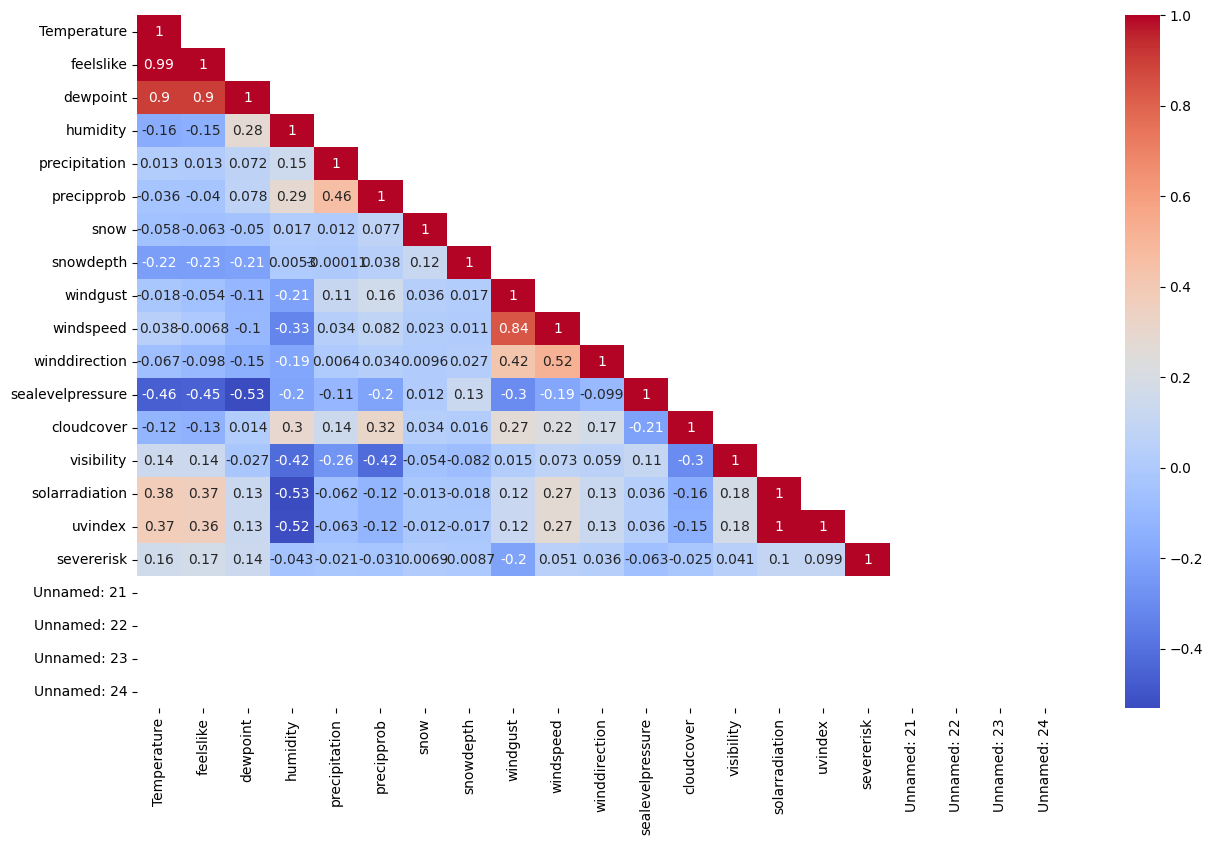

In [29]:
plt.figure(figsize=(15,9)) ;
mask = np.triu(np.ones_like(weather.corr(numeric_only=True), dtype=bool), k=1) ;
sb.heatmap(weather.corr(numeric_only=True), annot=True, mask=mask, cmap='coolwarm') ;

In [30]:
weather_dropped_columns = ['Name', 'datetime', 'preciptype', 'windgust', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25'] ;
weather = weather.drop(weather_dropped_columns, axis=1) ;
weather

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,38.0,34.4,29.0,69.76,0.0,0,0.0,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 01:00:00,38.0,34.4,29.9,72.37,0.0,0,0.0,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 02:00:00,38.0,35.7,30.8,75.06,0.0,0,0.0,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 03:00:00,37.1,33.4,29.9,74.97,0.0,0,0.0,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,1.0,Partially cloudy
2020-01-01 04:00:00,35.1,32.3,29.0,78.41,0.0,0,0.0,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,1.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,56.0,56.0,39.8,54.45,0.0,0,0.0,0.0,0.0,0.0,1008.6,0.0,9.9,0.0,0,10.0,Clear
2023-02-28 20:00:00,52.1,52.1,41.0,65.83,0.0,0,0.0,0.0,3.4,70.0,1008.3,0.0,9.9,0.0,0,10.0,Clear
2023-02-28 21:00:00,53.1,53.1,41.0,63.45,0.0,0,0.0,0.0,3.4,70.0,1008.4,0.0,9.9,0.0,0,10.0,Clear


In [31]:
weather.isnull().sum()

Temperature          0
feelslike            0
dewpoint             0
humidity             0
precipitation        0
precipprob           0
snow                18
snowdepth           18
windspeed            0
winddirection        0
sealevelpressure    18
cloudcover           0
visibility          18
solarradiation       0
uvindex              0
severerisk           0
conditions           0
dtype: int64

We need to filter the data upto Feb 21 only for training dataset !

In [32]:
weather = weather[weather.index < "2023-02-22 00:00:00"]
weather

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,38.0,34.4,29.0,69.76,0.0,0,0.0,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 01:00:00,38.0,34.4,29.9,72.37,0.0,0,0.0,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 02:00:00,38.0,35.7,30.8,75.06,0.0,0,0.0,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 03:00:00,37.1,33.4,29.9,74.97,0.0,0,0.0,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,1.0,Partially cloudy
2020-01-01 04:00:00,35.1,32.3,29.0,78.41,0.0,0,0.0,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,1.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,50.0,49.4,29.0,44.19,0.0,0,0.0,0.0,3.4,100.0,1009.1,50.0,9.9,0.0,0,10.0,Partially cloudy
2023-02-21 20:00:00,50.0,49.4,28.1,42.59,0.0,0,0.0,0.0,3.4,110.0,1008.1,88.9,9.9,0.0,0,10.0,Partially cloudy
2023-02-21 21:00:00,53.1,53.1,26.1,34.92,0.0,0,0.0,0.0,5.8,130.0,1007.3,100.0,9.9,0.0,0,10.0,Overcast


Preparing a combined training data

In [33]:
energy.index.is_unique

True

In [34]:
weather.index.is_unique

False

In [35]:
indices = energy.index ;
energy = energy.reset_index(drop=True) ;
weather = weather.reset_index(drop=True) ;

In [36]:
dataset = pd.concat([energy, weather], axis=1) ;
dataset.index = indices ;
ataset = dataset.sort_index() ;
dataset

,Demand (MW),Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered,...,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,445.8,0,1,1,1,January,2020,1,Wednesday,3,...,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 01:00:00,424.5,1,1,1,1,January,2020,1,Wednesday,3,...,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 02:00:00,423.5,2,1,1,1,January,2020,1,Wednesday,3,...,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,0,1.0,Overcast
2020-01-01 03:00:00,418.8,3,1,1,1,January,2020,1,Wednesday,3,...,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,0,1.0,Partially cloudy
2020-01-01 04:00:00,414.8,4,1,1,1,January,2020,1,Wednesday,3,...,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,0,1.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,498.7,19,21,1,2,February,2023,8,Tuesday,2,...,0.0,3.4,100.0,1009.1,50.0,9.9,0.0,0,10.0,Partially cloudy
2023-02-21 20:00:00,498.8,20,21,1,2,February,2023,8,Tuesday,2,...,0.0,3.4,110.0,1008.1,88.9,9.9,0.0,0,10.0,Partially cloudy
2023-02-21 21:00:00,506.4,21,21,1,2,February,2023,8,Tuesday,2,...,0.0,5.8,130.0,1007.3,100.0,9.9,0.0,0,10.0,Overcast


In [37]:
dataset = dataset.ffill()
dataset.isnull().sum()

Demand (MW)         0
Hour                0
Day                 0
Quarter             0
Month_Numbered      0
Month               0
Year                0
Week                0
Weekday             0
Weekday_Numbered    0
Temperature         0
feelslike           0
dewpoint            0
humidity            0
precipitation       0
precipprob          0
snow                0
snowdepth           0
windspeed           0
winddirection       0
sealevelpressure    0
cloudcover          0
visibility          0
solarradiation      0
uvindex             0
severerisk          0
conditions          0
dtype: int64

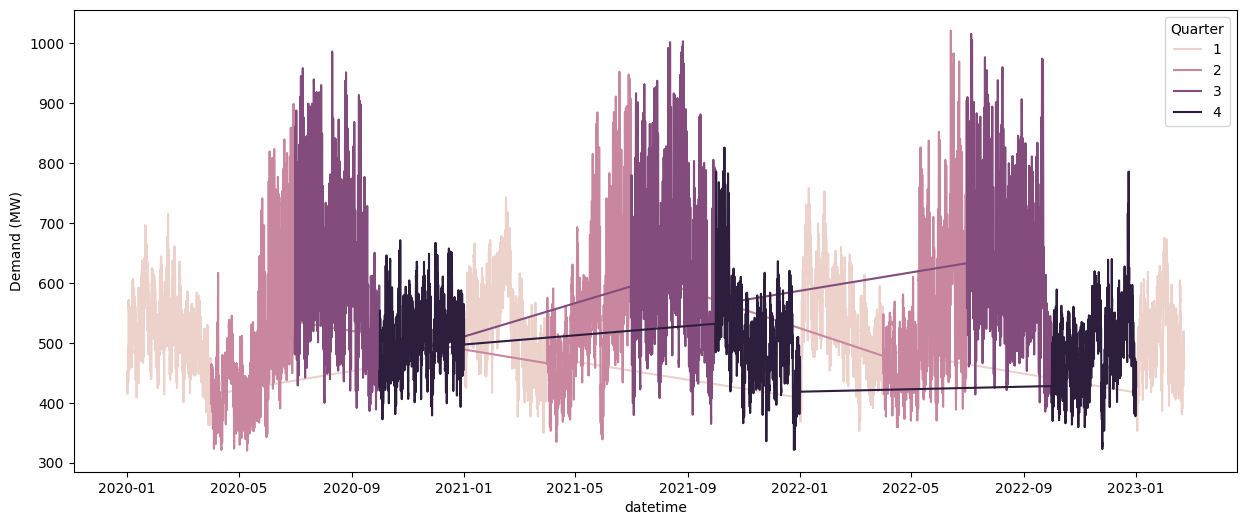

In [38]:
plt.figure(figsize=(15, 6))
sb.lineplot(data=dataset, x=dataset.index, y='Demand (MW)', hue='Quarter') ;

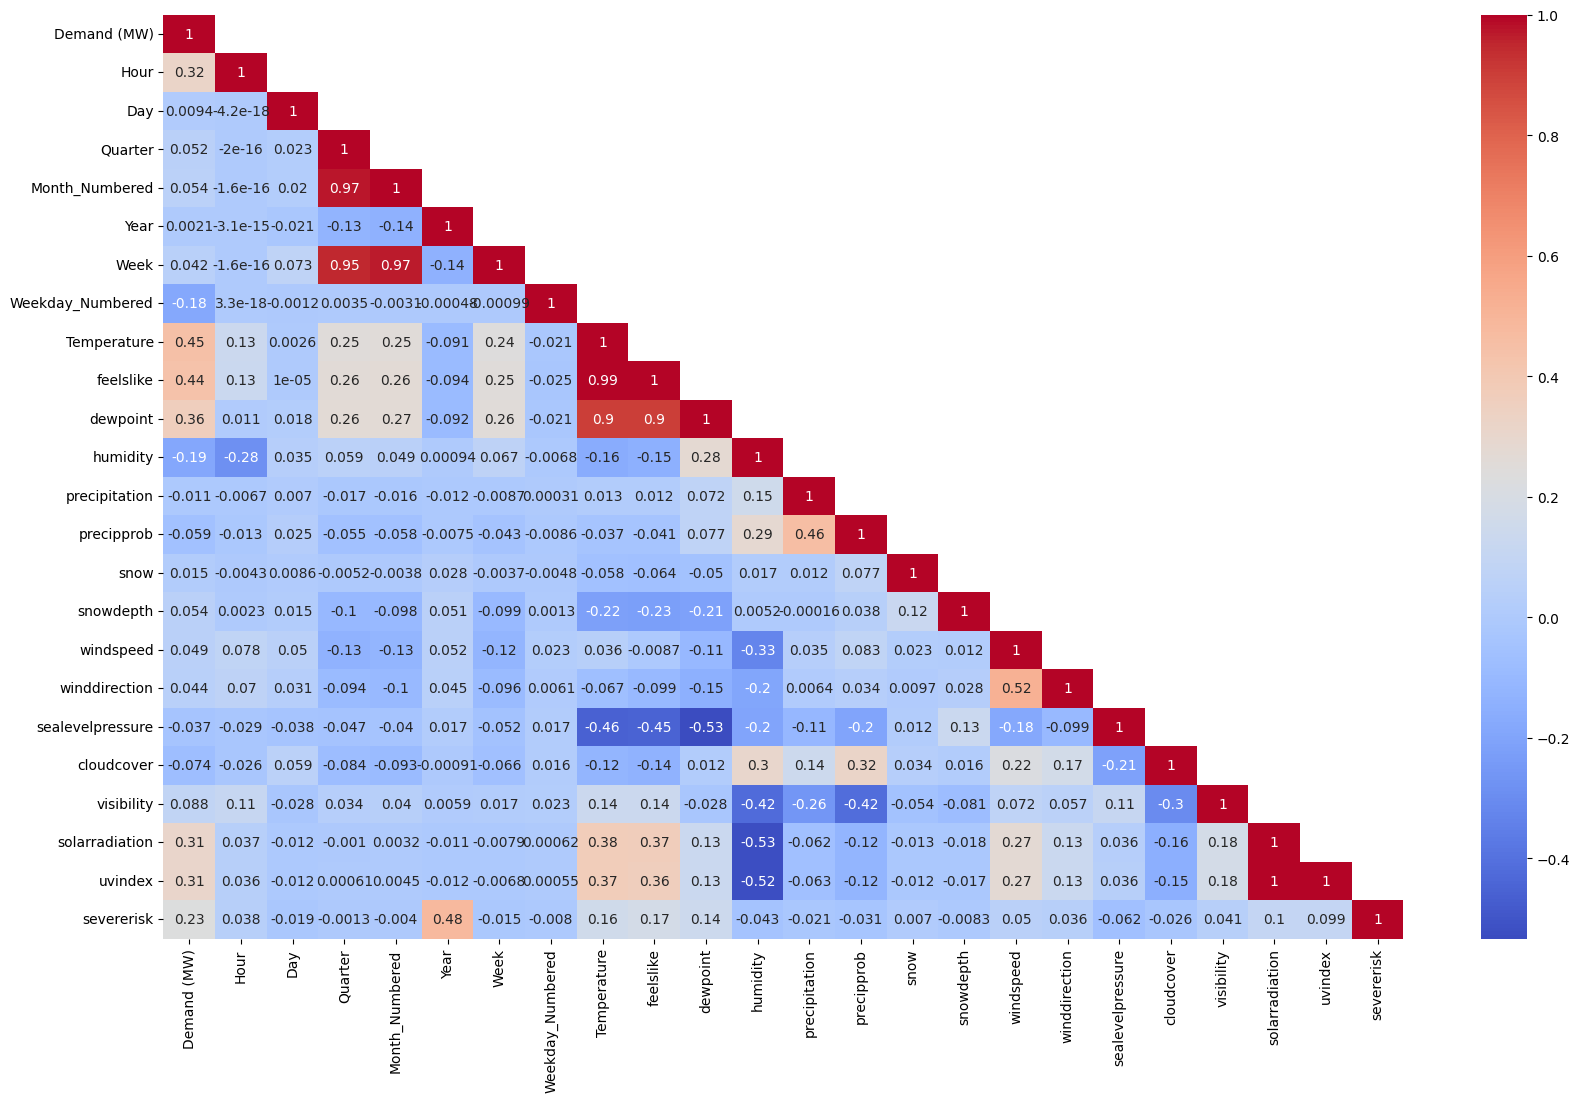

In [39]:
plt.figure(figsize=(20,12)) ;
mask = np.triu(np.ones_like(dataset.corr(numeric_only=True), dtype=bool), k=1) ;
sb.heatmap(dataset.corr(numeric_only=True), annot=True, mask=mask, cmap='coolwarm') ;

- UV Index is 100% correlated with solar radiation so, only one feature can be chosen !
- Similarly, 'Year' and 'Day' (not Weekday :) have very low correlation with the actual demand too ! This intuitively makes sense as well !
- 'Temperature', 'feelslike' and 'dewpoint' are highly correlated so, we use dewpoint and temperature to create a relative humidity metric.

In [40]:
dataset['rh'] = 100 - 5*(dataset['Temperature'] - dataset['dewpoint']) ;
dropped_columns = ['Temperature', 'dewpoint', 'Day', 'Month', 'Weekday', 'uvindex', 'conditions'] ;
dataset = dataset.drop(dropped_columns, axis=1) ;
y = dataset['Demand (MW)'] ;
x = dataset.drop('Demand (MW)', axis=1) ;
x

,Hour,Quarter,Month_Numbered,Year,Week,Weekday_Numbered,feelslike,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,severerisk,rh
datetime,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0,1,1,2020,1,3,34.4,69.76,0.0,0,0.0,0.0,4.7,220.0,1015.4,100.0,9.9,0.0,1.0,55.0
2020-01-01 01:00:00,1,1,1,2020,1,3,34.4,72.37,0.0,0,0.0,0.0,4.7,230.0,1015.3,100.0,9.9,0.0,1.0,59.5
2020-01-01 02:00:00,2,1,1,2020,1,3,35.7,75.06,0.0,0,0.0,0.0,3.4,230.0,1015.4,100.0,9.9,0.0,1.0,64.0
2020-01-01 03:00:00,3,1,1,2020,1,3,33.4,74.97,0.0,0,0.0,0.0,4.7,220.0,1015.3,88.9,9.9,0.0,1.0,64.0
2020-01-01 04:00:00,4,1,1,2020,1,3,32.3,78.41,0.0,0,0.0,0.0,3.4,240.0,1015.2,0.0,9.9,0.0,1.0,69.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-21 19:00:00,19,1,2,2023,8,2,49.4,44.19,0.0,0,0.0,0.0,3.4,100.0,1009.1,50.0,9.9,0.0,10.0,-5.0
2023-02-21 20:00:00,20,1,2,2023,8,2,49.4,42.59,0.0,0,0.0,0.0,3.4,110.0,1008.1,88.9,9.9,0.0,10.0,-9.5
2023-02-21 21:00:00,21,1,2,2023,8,2,53.1,34.92,0.0,0,0.0,0.0,5.8,130.0,1007.3,100.0,9.9,0.0,10.0,-35.0


In [41]:
dataset[((dataset['precipprob'] != 0) & (dataset['precipprob'] != 100))]

,Demand (MW),Hour,Quarter,Month_Numbered,Year,Week,Weekday_Numbered,feelslike,humidity,precipitation,...,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,severerisk,rh
datetime,,,,,,,,,,,,,,,,,,,,,


This suggests that there is either 100% probability of precipitation or zero. Probably a useless column !

In [42]:
from sklearn.model_selection import train_test_split ;
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, shuffle=False) ;
xtrain.shape

(22041, 20)

In [43]:
from sklearn.preprocessing import StandardScaler ;
sc = StandardScaler() ;
xtrain = pd.DataFrame(sc.fit_transform(xtrain), columns=xtrain.columns) ;
xtrain

,Hour,Quarter,Month_Numbered,Year,Week,Weekday_Numbered,feelslike,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,severerisk,rh
0,-1.660776,-1.195598,-1.454391,-1.071878,-1.556769,-0.499762,-0.995067,0.089040,-0.134103,-0.274651,-0.019439,-0.111042,-0.388568,0.506952,-0.375047,1.343721,0.377125,-0.629368,-0.298801,0.300247
1,-1.516323,-1.195598,-1.454391,-1.071878,-1.556769,-0.499762,-0.995067,0.233999,-0.134103,-0.274651,-0.019439,-0.111042,-0.388568,0.590292,-0.389901,1.343721,0.377125,-0.629368,-0.298801,0.408809
2,-1.371869,-1.195598,-1.454391,-1.071878,-1.556769,-0.499762,-0.934376,0.383401,-0.134103,-0.274651,-0.019439,-0.111042,-0.662140,0.590292,-0.375047,1.343721,0.377125,-0.629368,-0.298801,0.517370
3,-1.227415,-1.195598,-1.454391,-1.071878,-1.556769,-0.499762,-1.041752,0.378402,-0.134103,-0.274651,-0.019439,-0.111042,-0.388568,0.506952,-0.389901,1.096057,0.377125,-0.629368,-0.298801,0.517370
4,-1.082961,-1.195598,-1.454391,-1.071878,-1.556769,-0.499762,-1.093106,0.569459,-0.134103,-0.274651,-0.019439,-0.111042,-0.662140,0.673632,-0.404755,-0.887479,0.377125,-0.629368,-0.298801,0.650056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22036,-1.082961,0.625687,0.315791,1.589523,0.189160,0.000545,0.993724,1.400333,-0.018696,3.640988,-0.019439,-0.111042,0.326930,0.840312,-0.449316,1.343721,-1.608244,-0.629368,-0.046469,1.132550
22037,-0.938507,0.625687,0.315791,1.589523,0.189160,0.000545,0.937702,1.288698,2.589508,3.640988,-0.019439,-0.111042,-0.662140,0.840312,-0.508732,0.228121,-1.608244,-0.610646,-0.046469,1.060176
22038,-0.794054,0.625687,0.315791,1.589523,0.189160,0.000545,0.993724,1.400333,0.235200,3.640988,-0.019439,-0.111042,-1.377638,-1.326529,-0.523586,-0.887479,-1.608244,-0.112627,0.836694,1.132550
22039,-0.649600,0.625687,0.315791,1.589523,0.189160,0.000545,1.502593,1.088200,-0.134103,-0.274651,-0.019439,-0.111042,-1.377638,-1.326529,-0.479024,-0.278362,0.377125,0.052131,7.145001,0.903365


## Model Training

1. Support Vector Regressor (SVR)

In [44]:
from sklearn.svm import SVR ;
grid = {
    'kernel': ['linear', 'poly' , 'rbf'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1],
    'gamma': ['auto', 0.01, 0.1]
}

In [45]:
#gs = GridSearchCV(SVR(), grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_absolute_error') ;
#model = gs.fit(xtrain, ytrain) ;
#print(model.best_params_) ;

No need to keep doing it after once !
- hyperparameters = {'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}

In [46]:
svr_hp = {'C': 10, 'epsilon': 0.01, 'gamma': 'auto', 'kernel': 'rbf'} ;
svr = SVR(**svr_hp) ;
svr.fit(xtrain, ytrain)

SVR(C=10, epsilon=0.01, gamma='auto')

2. Random Forest Regressor

In [47]:
from sklearn.ensemble import RandomForestRegressor ;
gridDepth = np.arange(6,10) ;
gridMinSamples = np.arange(2,10) ;
gridMaxLeaves = np.arange(6,10) ;
rf_grid = {
                'n_estimators' : [100, 200, 500],
                'max_depth': gridDepth,
                'min_samples_leaf': gridMinSamples,
                'max_leaf_nodes': gridMaxLeaves
          } ;

In [48]:
#gsrf = GridSearchCV(RandomForestRegressor(), rf_grid, n_jobs=-1, verbose=2, cv=5, scoring='neg_mean_absolute_error') ;
#model = gsrf.fit(xtrain, ytrain) ;
#print(model.best_params_) ;

No need to keep doing it after once !
- hyperparameters = {'max_depth': 9, 'max_leaf_nodes': 9, 'min_samples_leaf': 7, 'n_estimators': 200}

In [49]:
rf_hp = {'max_depth': 9, 'n_estimators': 200, 'min_samples_leaf': 7} ;
rf = RandomForestRegressor(**rf_hp) ;
rf.fit(xtrain, ytrain)

RandomForestRegressor(max_depth=9, min_samples_leaf=7, n_estimators=200)

In [50]:
def plotFeatureImportances(model, xtrain):
  feature_importances = model.feature_importances_ ;
  indices = np.argsort(feature_importances)[::-1] ;
  feature_names = [f'{xtrain.columns[i]}' for i in indices] ;
  plt.figure(figsize=(8, 6)) ;
  plt.bar(range(xtrain.shape[1]), feature_importances[indices]) ;
  plt.xticks(range(xtrain.shape[1]), feature_names, rotation=90) ;
  plt.title("Feature Importances") ;
  plt.xlabel("Features") ;
  plt.ylabel("Importance") ;
  plt.show()

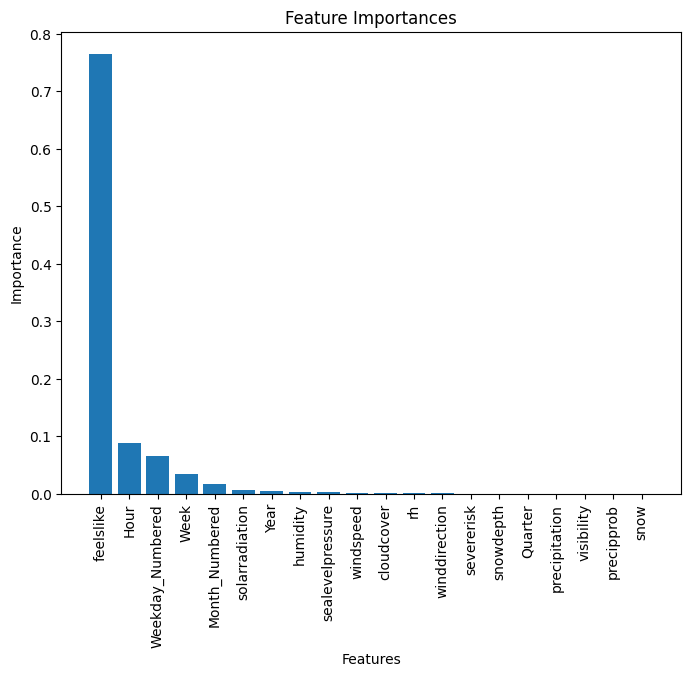

In [51]:
plotFeatureImportances(rf, xtrain) ;

3. XGB Regressor


In [52]:
from xgboost import XGBRegressor ;
xgb_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [500],
    'max_depth': [3, 5, 7],
    'gamma': [0, 1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 1, 5],
    'reg_lambda': [0, 1, 5]
} ;

In [53]:
#gsxgb = GridSearchCV(XGBRegressor(), xgb_grid, n_jobs=-1, verbose=2, cv=3, scoring='neg_mean_absolute_error') ;
#model = gsxgb.fit(xtrain, ytrain) ;
#print(model.best_params_) ;

No need to keep doing it after once !

  - hyperparameters = { 'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 5, 'reg_lambda': 0, 'subsample': 0.6}



In [54]:
xgb_hp = { 'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'reg_alpha': 5, 'reg_lambda': 0, 'subsample': 0.6} ;
xgb = XGBRegressor(**xgb_hp) ;
xgb.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

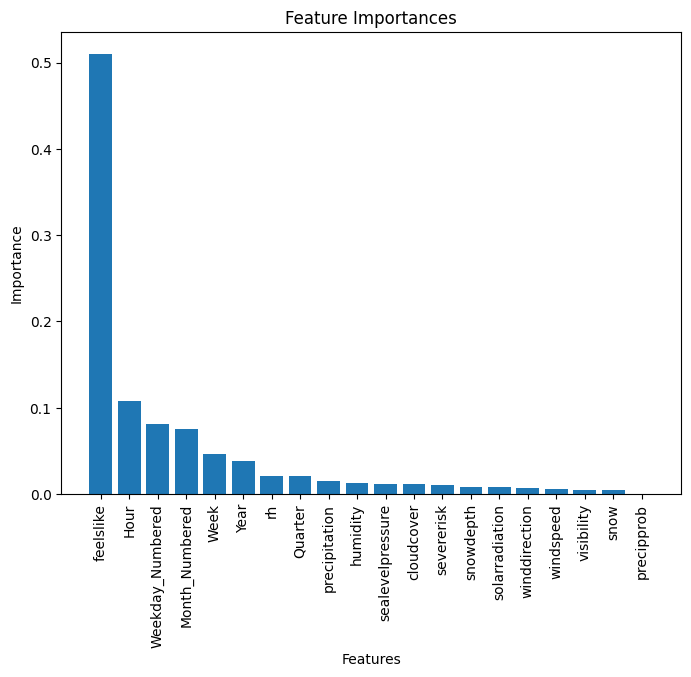

In [55]:
plotFeatureImportances(xgb, xtrain) ;

Using model on validation data

In [56]:
test = pd.DataFrame(sc.transform(xtest), columns=xtest.columns) ;

In [57]:
def plotValidationPrediction(model, test, ytest, title):
  # Prediction Plot
  validations = model.predict(test) ;
  validations = pd.DataFrame(index=xtest.index, data=validations, columns=['Predicted Demand (MW)']) ;
  plt.figure(figsize=(10,5)) ;
  ytest.plot(label='Actual Demand (MW)') ;
  validations['Predicted Demand (MW)'].plot(label='Predicted Demand') ;
  plt.legend() ;
  plt.title(title) ;
  # Metrics
  print('--'*50) ;
  print('Goodness of fit: ', r2_score(ytrain, model.predict(xtrain))) ;
  print('MAE: ', mean_absolute_error(ytest, validations)) ;
  print('R2 Score: ', r2_score(ytest, validations)) ;
  print('--'*50) ;

----------------------------------------------------------------------------------------------------
Goodness of fit:  0.853541648781891
MAE:  42.260641614308526
R2 Score:  0.782647757192726
----------------------------------------------------------------------------------------------------


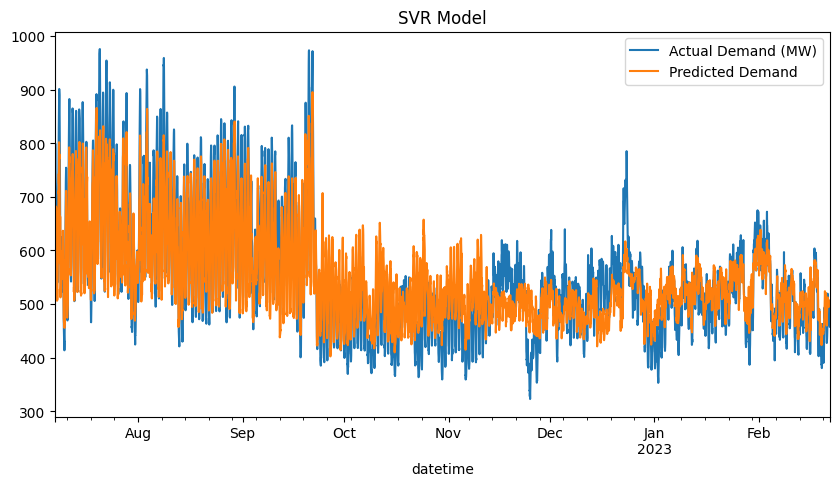

In [58]:
plotValidationPrediction(svr, test, ytest, 'SVR Model') ;

----------------------------------------------------------------------------------------------------
Goodness of fit:  0.9139823389612323
MAE:  33.081024184172705
R2 Score:  0.8476558630807963
----------------------------------------------------------------------------------------------------


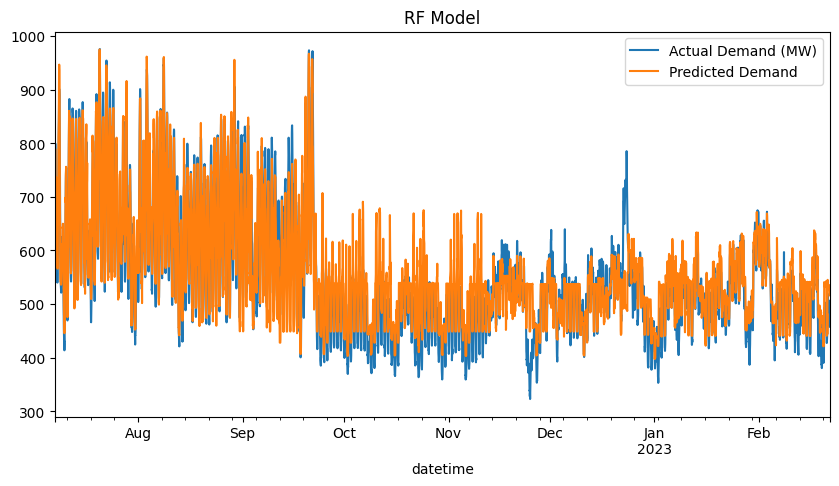

In [59]:
plotValidationPrediction(rf, test, ytest, 'RF Model') ;

----------------------------------------------------------------------------------------------------
Goodness of fit:  0.9770215202026266
MAE:  32.72797070653615
R2 Score:  0.8683171086386644
----------------------------------------------------------------------------------------------------


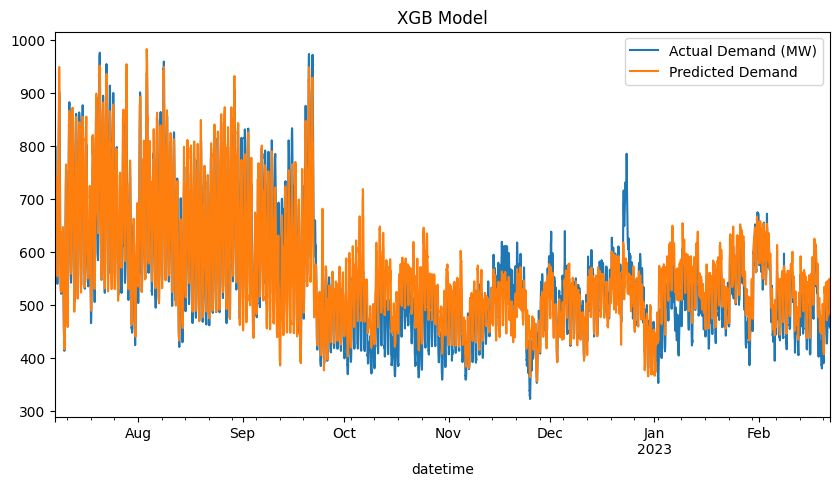

In [60]:
plotValidationPrediction(xgb, test, ytest, 'XGB Model') ;

Using model on test data

In [61]:
test = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Weather Data upto Feb 28.csv') ;
test.index = pd.to_datetime(test['datetime']) ;
test = test.sort_index() ;
test['rh'] = 100 - 5*(test['Temperature']-test['dewpoint']) ;
test = test[test.index > "2023-02-22 00:00:00"] ;
test = test.drop(weather_dropped_columns, axis=1) ;
test = test.ffill() ;
test

,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,uvindex,severerisk,conditions,rh
datetime,,,,,,,,,,,,,,,,,,
2023-02-22 01:00:00,56.9,56.9,35.1,43.72,0.0,0,0.0,0.0,6.9,140.0,1004.3,100.0,9.9,0.0,0,10.0,Overcast,-9.0
2023-02-22 02:00:00,56.9,56.9,38.0,49.13,0.0,0,0.0,0.0,4.7,130.0,1003.6,0.0,9.9,0.0,0,10.0,Clear,5.5
2023-02-22 03:00:00,57.8,57.8,41.0,53.38,0.0,0,0.0,0.0,8.1,160.0,1002.9,0.0,9.9,0.0,0,10.0,Clear,16.0
2023-02-22 04:00:00,57.8,57.8,46.1,64.98,0.0,0,0.0,0.0,11.4,170.0,1002.9,100.0,9.9,0.0,0,10.0,Overcast,41.5
2023-02-22 05:00:00,60.2,60.2,52.1,74.59,0.0,0,0.0,0.0,11.4,190.0,1003.0,50.0,9.9,0.0,0,10.0,Partially cloudy,59.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,56.0,56.0,39.8,54.45,0.0,0,0.0,0.0,0.0,0.0,1008.6,0.0,9.9,0.0,0,10.0,Clear,19.0
2023-02-28 20:00:00,52.1,52.1,41.0,65.83,0.0,0,0.0,0.0,3.4,70.0,1008.3,0.0,9.9,0.0,0,10.0,Clear,44.5
2023-02-28 21:00:00,53.1,53.1,41.0,63.45,0.0,0,0.0,0.0,3.4,70.0,1008.4,0.0,9.9,0.0,0,10.0,Clear,39.5


In [62]:
testPrefix = pd.DataFrame(test.index) ;
testPrefix = populateWithTimeFeatures(testPrefix, 'datetime') ;
testPrefix['Weekday_Numbered'] = testPrefix['Weekday'].map(weeks) ;
testPrefix = testPrefix.drop(['datetime'], axis=1) ;
testPrefix

,Hour,Day,Quarter,Month_Numbered,Month,Year,Week,Weekday,Weekday_Numbered
datetime,,,,,,,,,
2023-02-22 01:00:00,1,22,1,2,February,2023,8,Wednesday,3
2023-02-22 02:00:00,2,22,1,2,February,2023,8,Wednesday,3
2023-02-22 03:00:00,3,22,1,2,February,2023,8,Wednesday,3
2023-02-22 04:00:00,4,22,1,2,February,2023,8,Wednesday,3
2023-02-22 05:00:00,5,22,1,2,February,2023,8,Wednesday,3
...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,19,28,1,2,February,2023,9,Tuesday,2
2023-02-28 20:00:00,20,28,1,2,February,2023,9,Tuesday,2
2023-02-28 21:00:00,21,28,1,2,February,2023,9,Tuesday,2


In [63]:
test = pd.concat([testPrefix, test], axis=1) ;
test = test.drop(dropped_columns, axis=1) ;
test = pd.DataFrame(sc.transform(test), index = test.index, columns=test.columns) ;
test

,Hour,Quarter,Month_Numbered,Year,Week,Weekday_Numbered,feelslike,humidity,precipitation,precipprob,snow,snowdepth,windspeed,winddirection,sealevelpressure,cloudcover,visibility,solarradiation,severerisk,rh
datetime,,,,,,,,,,,,,,,,,,,,
2023-02-22 01:00:00,-1.516323,-1.195598,-1.159361,2.920223,-1.086711,-0.499762,0.055351,-1.357214,-0.134103,-0.274651,-0.019439,-0.111042,0.074401,-0.159768,-2.023826,1.343721,0.377125,-0.629368,0.836694,-1.243733
2023-02-22 02:00:00,-1.371869,-1.195598,-1.159361,2.920223,-1.086711,-0.499762,0.055351,-1.056744,-0.134103,-0.274651,-0.019439,-0.111042,-0.388568,-0.243109,-2.127803,-0.887479,0.377125,-0.629368,0.836694,-0.893925
2023-02-22 03:00:00,-1.227415,-1.195598,-1.159361,2.920223,-1.086711,-0.499762,0.097368,-0.820700,-0.134103,-0.274651,-0.019439,-0.111042,0.326930,0.006912,-2.231780,-0.887479,0.377125,-0.629368,0.836694,-0.640616
2023-02-22 04:00:00,-1.082961,-1.195598,-1.159361,2.920223,-1.086711,-0.499762,0.097368,-0.176439,-0.134103,-0.274651,-0.019439,-0.111042,1.021383,0.090252,-2.231780,1.343721,0.377125,-0.629368,0.836694,-0.025436
2023-02-22 05:00:00,-0.938507,-1.195598,-1.159361,2.920223,-1.086711,-0.499762,0.209412,0.357297,-0.134103,-0.274651,-0.019439,-0.111042,1.021383,0.256932,-2.216926,0.228121,0.377125,-0.629368,0.836694,0.408809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,1.083846,-1.195598,-1.159361,2.920223,-1.019560,-1.000068,0.013334,-0.761273,-0.134103,-0.274651,-0.019439,-0.111042,-1.377638,-1.326529,-1.385110,-0.887479,0.377125,-0.629368,0.836694,-0.568242
2023-02-28 20:00:00,1.228300,-1.195598,-1.159361,2.920223,-1.019560,-1.000068,-0.168738,-0.129231,-0.134103,-0.274651,-0.019439,-0.111042,-0.662140,-0.743149,-1.429671,-0.887479,0.377125,-0.629368,0.836694,0.046938
2023-02-28 21:00:00,1.372754,-1.195598,-1.159361,2.920223,-1.019560,-1.000068,-0.122053,-0.261415,-0.134103,-0.274651,-0.019439,-0.111042,-0.662140,-0.743149,-1.414817,-0.887479,0.377125,-0.629368,0.836694,-0.073685


Demand Forecasting

In [64]:
prevData = pd.read_csv('/content/drive/MyDrive/Demand Forecasting Demand Data upto Feb 21.csv') ;
prevData['datetime'] = pd.to_datetime(prevData['datetime']) ;
prevData = prevData[prevData['datetime'] > "2023-01-31 23:00:00"]  ;
prevData.index = pd.to_datetime(prevData['datetime']) ;
prevData = prevData.drop('datetime', axis=1) ;
prevData

,Demand (MW)
datetime,
2023-02-01 00:00:00,611.9
2023-02-01 01:00:00,575.1
2023-02-01 02:00:00,575.5
2023-02-01 03:00:00,582.4
2023-02-01 04:00:00,586.0
...,...
2023-02-21 19:00:00,498.7
2023-02-21 20:00:00,498.8
2023-02-21 21:00:00,506.4


In [65]:
def forecast(model, test, title):
  plt.figure(figsize=(12, 6)) ;
  predictions = model.predict(test) ;
  predictions = pd.DataFrame(index=test.index, data=predictions, columns=['Predicted Demand (MW)']) ;
  predictions.to_csv(f'/content/drive/MyDrive/{title}.csv') ;
  prevData['Demand (MW)'].plot(label= 'Demand (MW)')
  predictions['Predicted Demand (MW)'].plot(label= 'Forecasted Demand (MW)') ;
  plt.title(title) ;
  plt.xticks(rotation=90) ;
  plt.legend() ;
  return predictions ;

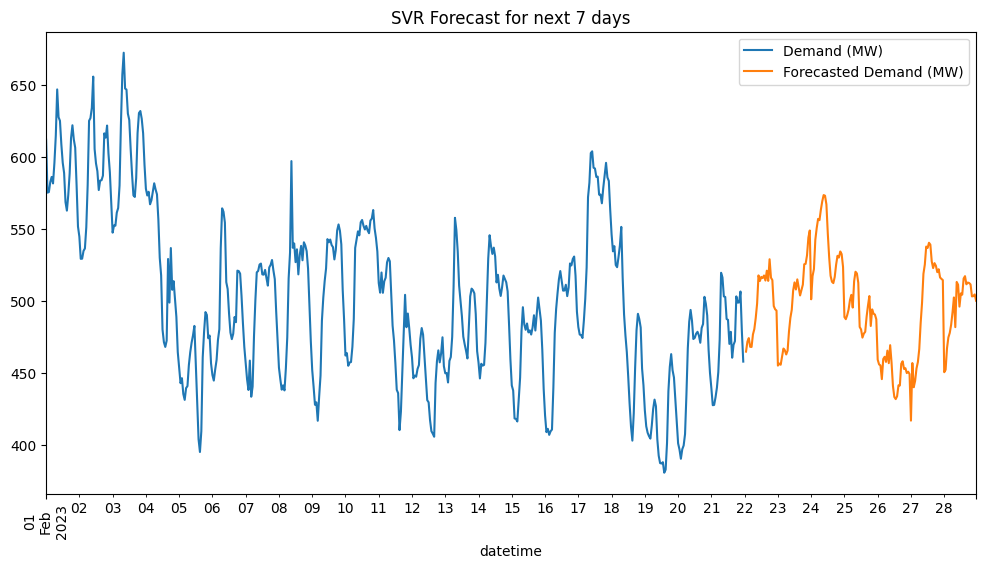

In [66]:
svr_predictions = forecast(svr, test, 'SVR Forecast for next 7 days') ;

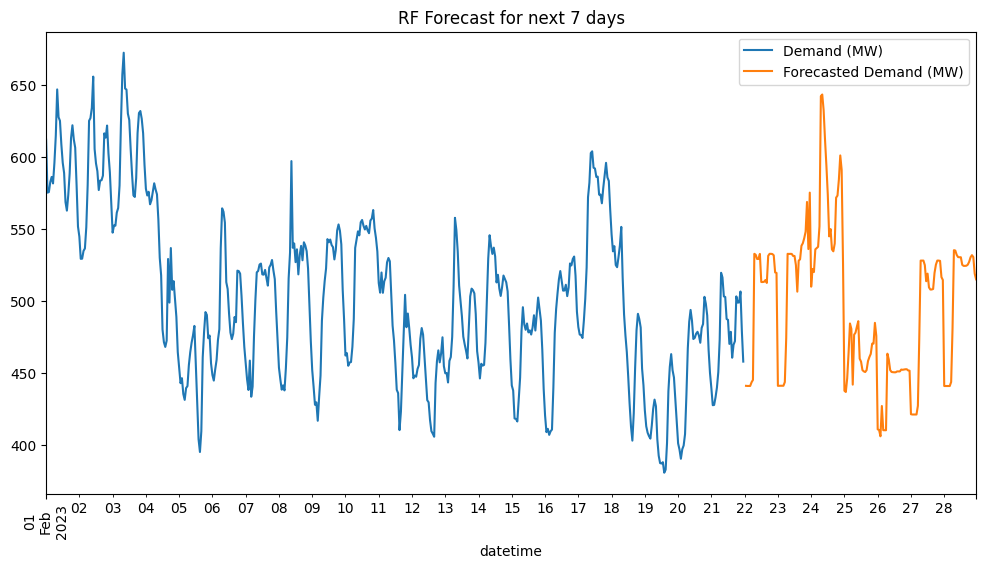

In [67]:
svr_predictions = forecast(rf, test, 'RF Forecast for next 7 days') ;

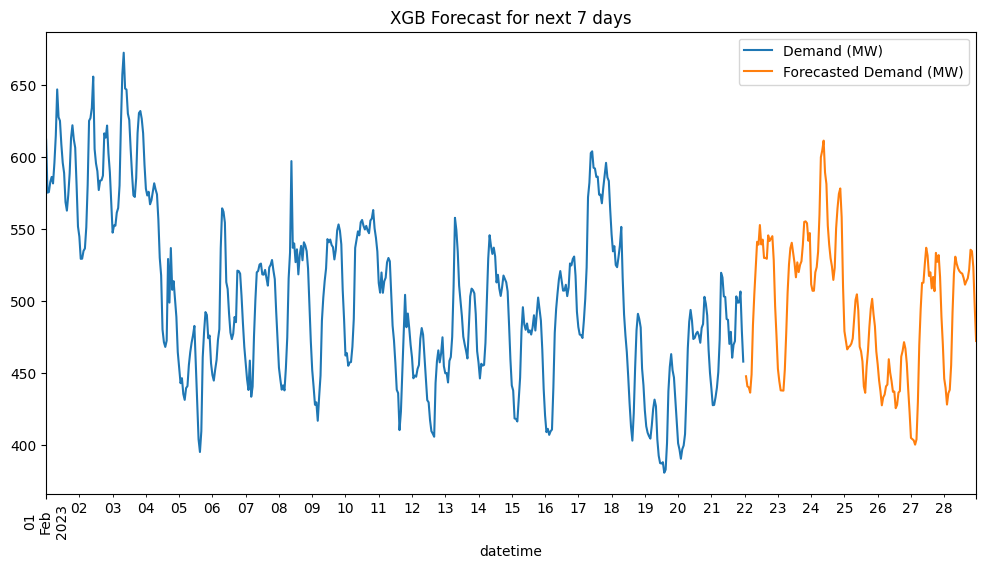

In [68]:
svr_predictions = forecast(xgb, test, 'XGB Forecast for next 7 days') ;